In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.colors as mcolors
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [186]:
np.random.seed(42)

In [187]:
dados = pd.read_csv("../src/dados_completos.csv")

Inicialmente eu vou pegar os dados e fazer a média de cada mês por cidade, então teremos os dados na seguinte disposição:

\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Cidade} & 01 & 02 & 03 & \cdots & 12 \\
\hline
\text{Abreu e Lima} & 7.61 & 10.58 & 9.12 & \cdots & 8.95 \\
\text{Afogados...} & 5.23 & 6.89 & 7.45 & \cdots & 4.12 \\
\hline
\end{array}

In [188]:
# Criar features mensais médias para cada cidade
monthly_avg = dados.groupby(['Cidade', dados['Data'].str.split('-').str[1]])['Precipitacao_mm_mes'].mean().unstack()
monthly_avg.columns = [f'Precip_Media_Mes_{i+1:02d}' for i in range(12)]

Abaixo eu vou pegar as informações de Latitude, Logitude e Mesorregião de cada cidade e em seguinte vou agrupar, 
então os dados vão ficar com a seguinte diposição:
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
\text{Cidade} & \text{01} & \text{02} & \text{03} & \cdots & \text{12} & \text{Latitude} & \text{Longitude} & \text{Mesorregião} \\
\hline
\text{Abreu e Lima} & 7.61 & 10.58 & 9.12 & \cdots & 8.95 & -7.9116 & 34.90 & \text{Metropolitana do Recife} \\
\hline
\text{Afogados...} & 5.23 & 6.89 & 7.45 & \cdots & 4.12 & -7.75 & 37.64 & \text{Sertão Pernambucano} \\
\hline
\end{array}

In [189]:
# Adicionar informações geográficas
cidades_info = dados.groupby('Cidade')[['Latitude', 'Longitude', 'Mesorregião']].first()
dados_agregados = monthly_avg.merge(cidades_info, left_index=True, right_index=True)

Estou preparando dados para um modelo de Naive Bayes (classificador). O Naive Bayes precisa de uma variável target (alvo) que são as classes a serem previstas

In [190]:
dados_agregados['Target'] = dados_agregados['Mesorregião']

Primeiro cria uma lista com a precipitação dos 12 meses do ano.

* X representa a matriz de features (variáveis independentes)

* y representa o vetor de labels/classes (mesorregiões)

Depois Normaliza os dados

In [191]:
# Preparar features e target
features = [f'Precip_Media_Mes_{i+1:02d}' for i in range(12)]
X = dados_agregados[features]
y = dados_agregados['Target']

# Normalizar os dados (importante para GaussianNB)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

A seguir fazemos a divisão de train e test, escolhi 30% para fazer o teste o 70% para treinar

In [192]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

Primeiro eu criei uma "máquina de classificação" vazia baseada no Teorema de Bayes e depois indiquei as variáveis de treinamento

In [193]:
modelo_nb = GaussianNB()
modelo_nb.fit(X_train, y_train)

GaussianNB()

Faz as precisões

In [194]:
y_pred = modelo_nb.predict(X_test)
y_pred_proba = modelo_nb.predict_proba(X_test)

* A acurácia mede a porcentagem de cidades classificadas corretamente
* Depois vejo a quais das cidades que o modelo classifcou como Sertão quantas são realemnte são Sertão
    * Precision: "De todas as vezes que o modelo disse que a cidade era X, quantas vezes ele acertou?"
    * Recall: De todas as cidades que SÃO realmente X, quantas o modelo conseguiu encontrar?"
    * F1: É a média harmônica (um balanceamento) entre Precision e Recall. É uma métrica importante quando há um desequilíbrio entre as classes.
    * O número de instâncias (cidades) dessa classe no conjunto de teste

Eu estou tentando avaliar o quão bem o modelo K-NN conseguiu replicar as Mesorregiões oficiais (os rótulos de verdade fundamental) usando as características (provavelmente, a precipitação média mensal)

In [195]:
print("\n=== AVALIAÇÃO DO MODELO ===")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2%}")

print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_test, y_pred))


=== AVALIAÇÃO DO MODELO ===
Acurácia: 48.21%

=== RELATÓRIO DE CLASSIFICAÇÃO ===
                            precision    recall  f1-score   support

      Agreste Pernambucano       0.58      1.00      0.74        21
         Mata Pernambucana       0.00      0.00      0.00        13
   Metropolitana do Recife       1.00      0.20      0.33         5
       Sertão Pernambucano       0.00      0.00      0.00        12
São Francisco Pernambucano       0.31      1.00      0.48         5

                  accuracy                           0.48        56
                 macro avg       0.38      0.44      0.31        56
              weighted avg       0.34      0.48      0.35        56



c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mclar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

* Acurácia: 48.21% significa que o modelo acertou menos da metade das classificações. É praticamente um chute.
* Precision indica quantas cidades naquela região foi dada como certa
* Recal indica quantas cidades da região foram classificadas como relamente daquelas regiões

Conclusão que eu tirei: As mesorregiões não têm padrões de precipitação suficientemente distintos para serem separadas apenas pela chuva mensal. O modelo está agrupando quase tudo no Agreste e São Francisco, sugerindo que o Agreste tem o padrão de chuva "mais comum" ou "mais médio" e Mata e Sertão têm padrões que se confundem com outras regiões

Fiz uma matrix de confusão para entender como o modelo está funcionando. Indica o resultado  que tivemos no bloco anterior

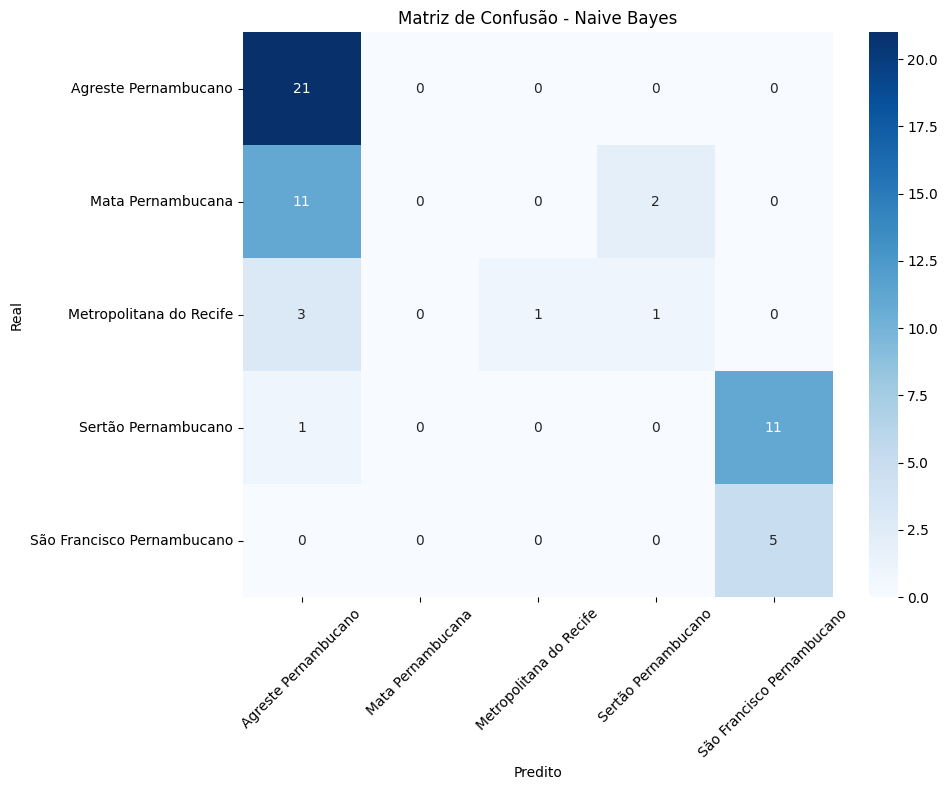

In [196]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=modelo_nb.classes_, 
            yticklabels=modelo_nb.classes_)
plt.title('Matriz de Confusão - Naive Bayes')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Indica a probabilidade de cada cidade fica em cada região

In [197]:
probabilidades_por_classe = pd.DataFrame(
    modelo_nb.predict_proba(X_scaled),
    columns=modelo_nb.classes_,
    index=dados_agregados.index
)

# Adicionar a classe real e a predita
probabilidades_por_classe['Classe_Real'] = y
probabilidades_por_classe['Classe_Predita'] = modelo_nb.predict(X_scaled)

print("\nProbabilidades para algumas cidades das 10 primeiras cidadades:")
probabilidades_por_classe.head(10)


Probabilidades para algumas cidades das 10 primeiras cidadades:


,Agreste Pernambucano,Mata Pernambucana,Metropolitana do Recife,Sertão Pernambucano,São Francisco Pernambucano,Classe_Real,Classe_Predita
Cidade,,,,,,,
Abreu e Lima,0.0,3.039878e-42,1.000000e+00,2.772140e-14,0.000000,Metropolitana do Recife,Metropolitana do Recife
Afogados da Ingazeira,0.0,8.173745e-239,0.000000e+00,2.815521e-03,0.997184,Sertão Pernambucano,São Francisco Pernambucano
Afrânio,0.0,0.000000e+00,0.000000e+00,4.208172e-03,0.995792,São Francisco Pernambucano,São Francisco Pernambucano
Agrestina,1.0,1.502365e-47,7.935262e-54,1.411860e-59,0.000000,Agreste Pernambucano,Agreste Pernambucano
Alagoinha,1.0,1.502365e-47,7.935262e-54,1.411860e-59,0.000000,Agreste Pernambucano,Agreste Pernambucano
Aliança,1.0,1.502365e-47,7.935262e-54,1.411860e-59,0.000000,Mata Pernambucana,Agreste Pernambucano
Altinho,1.0,1.502365e-47,7.935262e-54,1.411860e-59,0.000000,Agreste Pernambucano,Agreste Pernambucano
Amaraji,1.0,1.502365e-47,7.935262e-54,1.411860e-59,0.000000,Mata Pernambucana,Agreste Pernambucano
Angelim,1.0,1.502365e-47,7.935262e-54,1.411860e-59,0.000000,Agreste Pernambucano,Agreste Pernambucano


Adicionar as previsões do Naive Bayes ao DataFrame para todos os dados

In [198]:
X_all_scaled = scaler.transform(X)
y_pred_all = modelo_nb.predict(X_all_scaled)
y_pred_proba_all = modelo_nb.predict_proba(X_all_scaled)

# Adicionar ao DataFrame
dados_agregados['Predicao_NaiveBayes'] = y_pred_all
dados_agregados['Confiança'] = np.max(y_pred_proba_all, axis=1)

* O primeiro plot mostra geograficamente os clusteres. Ele pega a latitude e a longitude de cada cidade e mostra a que cluster pertence
* O segundo mostra a matrix de congusão dos dados dizendo quantas cidades ficaram na nova mesorregião

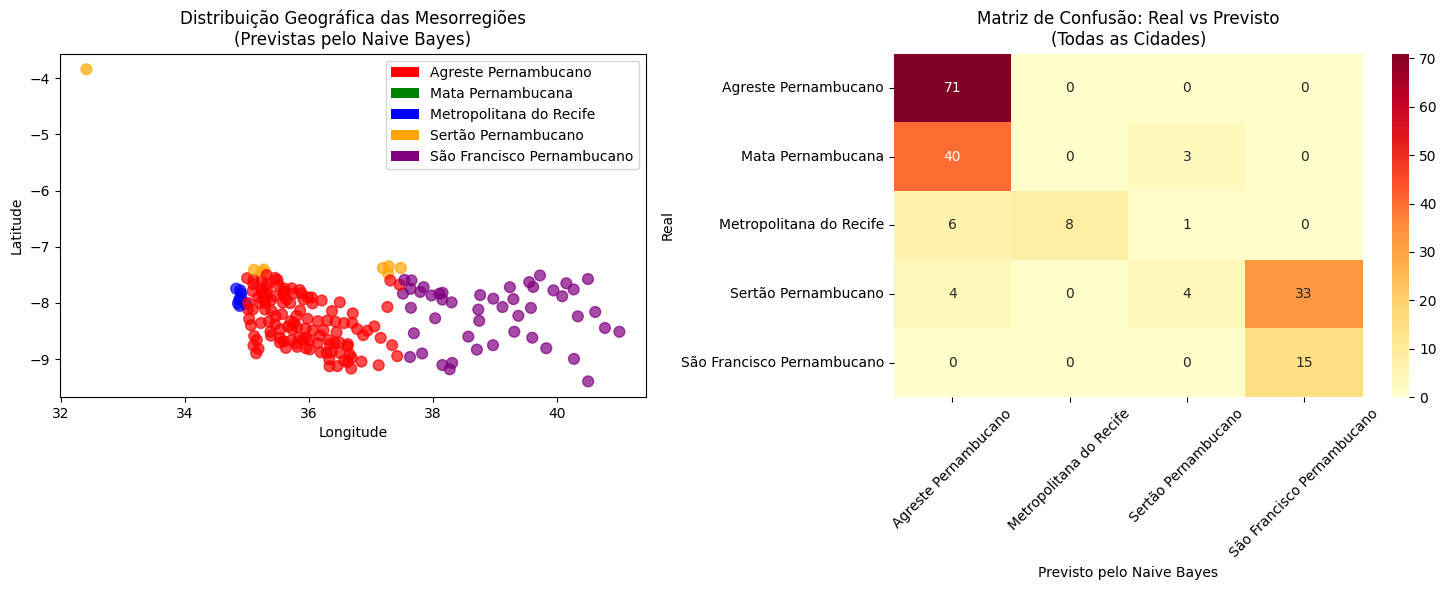

In [203]:
plt.figure(figsize=(15, 6))
plt.subplots_adjust(wspace=0.4)

# Plot 1: Distribuição geográfica das mesorregiões 
plt.subplot(1, 2, 1)
cores_mesorregioes = {
    'Agreste Pernambucano': 'red', 
    'Mata Pernambucana': 'green', 
    'Metropolitana do Recife': 'blue',
    'Sertão Pernambucano': 'orange', 
    'São Francisco Pernambucano': 'purple'
}

# Usar as previsões do Naive Bayes
dados_plot = dados_agregados.dropna(subset=['Predicao_NaiveBayes'])
cores_lista = []
for predicao in dados_plot['Predicao_NaiveBayes']:
    cores_lista.append(cores_mesorregioes.get(predicao, 'gray'))

scatter = plt.scatter(dados_plot['Longitude'], dados_plot['Latitude'], 
                     c=cores_lista, s=60, alpha=0.7)
plt.title('Distribuição Geográfica das Mesorregiões\n(Previstas pelo Naive Bayes)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Criar legenda manual
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=regiao) 
                   for regiao, color in cores_mesorregioes.items()]
plt.legend(handles=legend_elements, loc='best')

# Plot 2: Comparação entre Real e Previsto (todas as cidades)
plt.subplot(1, 2, 2)
cross_tab = pd.crosstab(dados_agregados['Target'], dados_agregados['Predicao_NaiveBayes'])
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Matriz de Confusão: Real vs Previsto\n(Todas as Cidades)')
plt.xlabel('Previsto pelo Naive Bayes')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

Mostrando como ficou a distribuição de cidades por mesorregião

In [200]:
for mesorregiao in sorted(dados_agregados['Predicao_NaiveBayes'].unique()):
    cidades_mesorregiao = dados_agregados[dados_agregados['Predicao_NaiveBayes'] == mesorregiao].index.tolist()
    print(f"--- {mesorregiao} ({len(cidades_mesorregiao)} cidades) ---")
    print(f"Cidades: {', '.join(sorted(cidades_mesorregiao))}")
    print()

--- Agreste Pernambucano (121 cidades) ---
Cidades: Agrestina, Alagoinha, Aliança, Altinho, Amaraji, Angelim, Araçoiaba, Arcoverde, Barra de Guabiraba, Barreiros, Belo Jardim, Belém de Maria, Bezerros, Bom Conselho, Bom Jardim, Bonito, Brejo da Madre de Deus, Brejão, Buenos Aires, Buíque, Cabo de Santo Agostinho, Cachoeirinha, Caetés, Calçado, Camocim de São Félix, Canhotinho, Capoeiras, Carpina, Caruaru, Casinhas, Catende, Chã Grande, Chã de Alegria, Condado, Correntes, Cortês, Cumaru, Cupira, Escada, Feira Nova, Frei Miguelinho, Gameleira, Garanhuns, Glória do Goitá, Goiana, Gravatá, Iati, Ibirajuba, Ingazeira, Ipojuca, Itaquitinga, Itaíba, Jaboatão dos Guararapes, Jaqueira, Jataúba, Joaquim Nabuco, João Alfredo, Jucati, Jupi, Jurema, Lagoa de Itaenga, Lagoa do Carro, Lagoa do Ouro, Lagoa dos Gatos, Lajedo, Limoeiro, Macaparana, Machados, Maraial, Moreno, Nazaré da Mata, Orobó, Palmares, Palmeirina, Panelas, Paranatama, Passira, Paudalho, Pedra, Pesqueira, Pombos, Poção, Primavera, Q